# Setup and Load Data

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [ ]:
!pip install opencv-python
!pip install matplotlib

In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## Removing Dodgy images

In [3]:
import cv2
import imghdr
from matplotlib import pyplot as plt


In [4]:
img=cv2.imread(os.path.join('data','happy','GettyImages-871518740-1024x707.jpg'))

In [5]:
img.shape

(707, 1024, 3)

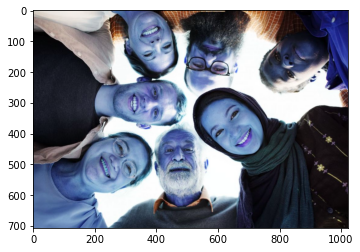

In [6]:
plt.imshow(img)

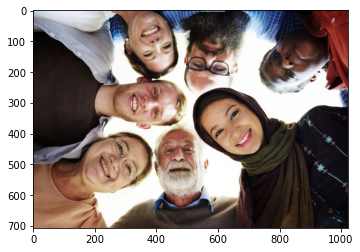

In [7]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

In [8]:
data_dir='data'

In [9]:
image_exts=['jpeg','jpg','bmp','png']

In [10]:
#removal of dodgy image
for image_class in os.listdir(data_dir): #looping through every folder in list_dir
    for image in os.listdir(os.path.join(data_dir, image_class)):#Acces every single image in that subdirectory
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# Load Data

In [11]:
tf.data.Dataset??

In [12]:
import numpy as np

In [13]:
data=tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [14]:
# converting data to data iterator to access the files from it 
data_iterator = data.as_numpy_iterator()

In [15]:
#Get another batch of data
batch= data_iterator.next()

In [16]:
#images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [17]:
# class 1= SAD
# Class 0= Happy
batch[1]

array([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1])

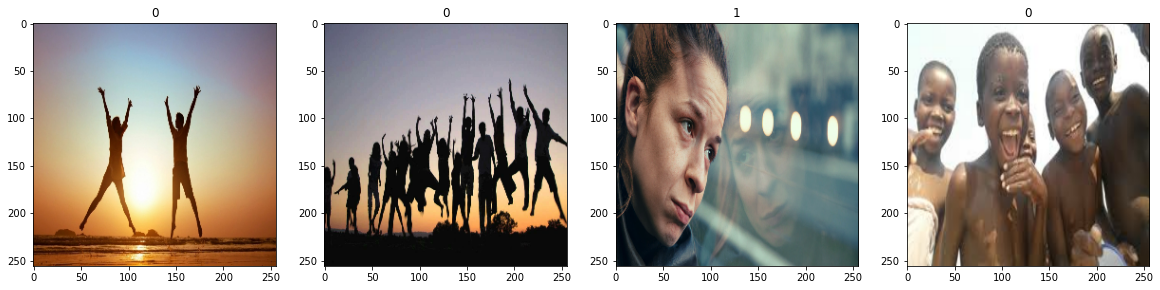

In [18]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Processing Data

In [19]:
### Scale Data

data= data.map(lambda x,y:(x/255,y))

In [20]:
scaled_iterator=data.as_numpy_iterator()

In [21]:
batch_scaled=scaled_iterator.next()

In [22]:
batch_scaled[0].max()

1.0

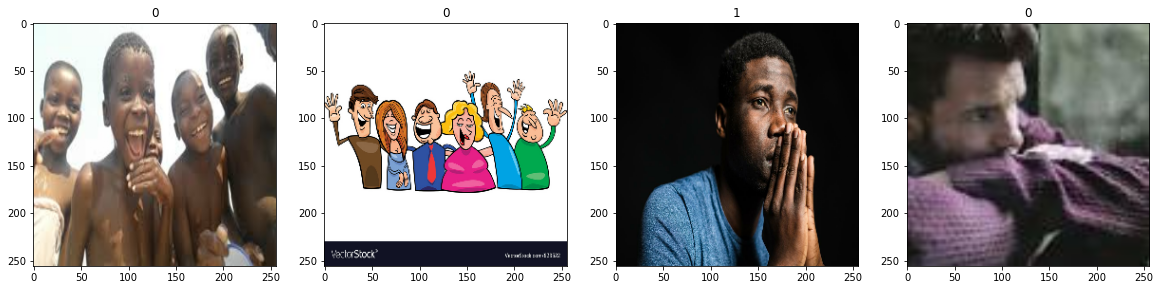

In [23]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch_scaled[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [24]:
## test train split

len(data)

10

In [25]:
train_size=int(len(data)*0.7)
val_size=int(len(data)*0.2)
test_size= int(len(data)*0.1)

In [26]:
train_size

7

In [27]:
train=data.take(train_size)
val=data.skip(train_size).take(val_size)
test=data.skip(train_size+val_size).take(test_size)

In [28]:
len(test)

1

# Model Developement

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [30]:
model=Sequential()

In [31]:
#Adding a convolutional layer 
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [32]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# Train 

In [34]:
logdir='logs'

In [35]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist=model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


# Plot Performane

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluation of Model

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre=Precision()
re= Recall()
acc=BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    X,y=batch
    yhat=model.predict(X)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)

In [ ]:
print(f'Precision Result: {pre.result().numpy()},Recall Result: {re.result().numpy()},Accuracy Result :{acc.result().numpy()}')

# Test

In [ ]:
import cv2

In [ ]:
img=cv2.imread('05-12-21-happy-people.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()
            

In [ ]:
resize=tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat=model.predict(np.expand_dims(resize/256,0))

In [ ]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

# Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','finalmodel.h5'))

In [ ]:
new_model= load_model(os.path.join('models','finalmodel.h5'))

In [ ]:
new_model

In [ ]:
yhat_new=new_model.predict(np.expand_dims(resize/256,0))

In [ ]:
if yhat_new > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')